# Simple Example that implement a basic moving-average crossover strategy with AAPL stock
### Buy AAPL if 50-day moving-average cross above 200-day moving-average

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [14]:
import pytz
from datetime import datetime

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_bars_from_yahoo

# Load data manually from Yahoo! finance
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2016, 5, 4, 0, 0, 0, 0, pytz.utc)

data = load_bars_from_yahoo(stocks=['SPY'], start=start,
                            end=end)

SPY


In [15]:
from zipline.api import order_target_percent, record, symbol, history, add_history
import numpy as np

def initialize(context):
    # Register 2 histories that track daily prices,
    # one with a 100 window and one with a 300 day window
    add_history(50, '1d', 'price')
    add_history(200, '1d', 'price')

    context.trade_count = 0
    
    context.i = 0

def handle_data(context, data):
    # Skip first 300 days to get full windows of data before running any trading logic
    context.i += 1
    if context.i < 300:
        return

    # Compute moving-averages below
    # history() has to be called with the same params as used above in the initialize method 'add_history' calls
    # history() returns a pandas dataframe.
    
    short_mavg = history(50, '1d', 'price').mean()
    long_mavg = history(200, '1d', 'price').mean()

    # Trading logic
    if short_mavg[0] > long_mavg[0]:
        # only enter this trade if you are not already in a previous trade
        if len(context.portfolio.positions) < 1:
            context.trade_count += 1
            print "Trade: " + str(context.trade_count)
            # order_target_percent orders as many shares as needed to invest X% of your account value.
            order_target_percent(symbol('SPY'), 1.0)
    elif short_mavg[0] < long_mavg[0]:
        order_target_percent(symbol('SPY'), 0)

    # Save values for later inspection
    record(AAPL_price=data[symbol('SPY')].price,
           short_mavg=short_mavg[0],
           long_mavg=long_mavg[0])

In [16]:
# Create algorithm object passing in initialize() and handle_data() functions
algo_obj = TradingAlgorithm(initialize=initialize,
                            handle_data=handle_data)

# Run algorithm
perf_manual = algo_obj.run(data)

Trade: 1
Trade: 2
Trade: 3
Trade: 4
Trade: 5
Trade: 6
Trade: 7
Trade: 8
Trade: 9


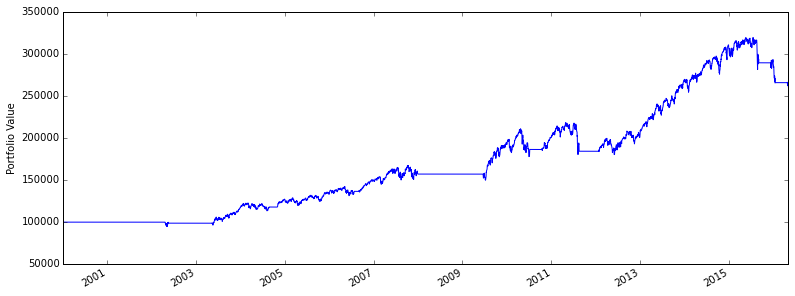

In [17]:
figsize(13,5)
perf_manual.portfolio_value.plot()
plt.ylabel("Portfolio Value")

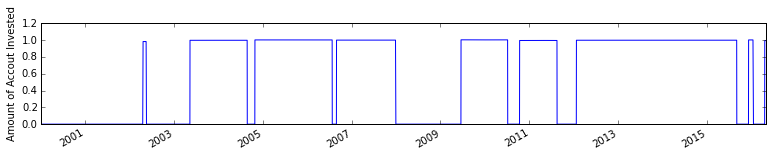

In [18]:
figsize(13,2)
# gross_leverage shows you how much of your portfolio was invested each day
# in this case it goes between 0 and 1 depending on if we were holding AAPL in our algo

perf_manual.gross_leverage.plot()
plt.ylabel("Amount of Accout Invested")